In [1]:
### importing packages
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import os

In [2]:
# find Dropbox parent directory
cwd = os.getcwd().split('/')
HOME = cwd[1:cwd.index('Dropbox')]
HOME = "/"+"/".join(HOME)

import planck_colormap
cm = planck_colormap.colormap()

In [3]:
nside = 64
lmax = 3*nside//2

In [4]:
## power spectra
### importing Cls

#ClsAddress = HOME + "/Dropbox/Doutorado/Research/Healpy/PlanckPR2_TT_lowp_lensing_totCls.dat"
ClsAddress = HOME + "/Dropbox/Doutorado/Research/"+\
"Resources for coding - Power Spectra - Maps etc/Power Spectra/PlanckPR2_TT_lowp_lensing_lensedCls.dat"
l, DlTT = np.loadtxt(ClsAddress, unpack=True, usecols=(0,1)) # Full
ClTT = ((2*np.pi)/(l*(l+1)))*(DlTT)
l = np.append([0,1],l)
ClTT = np.append([0,0],(ClTT))

In [5]:
#np.save('input_files/cls_PlanckPR2_TT_lowp_lensing_lensed', ClTT)

In [6]:
### maps and mask

In [9]:
# for mask
commanderaddress = HOME+"/Dropbox/Doutorado/Research/\
Resources for coding - Power Spectra - Maps etc/Maps/COM_CompMap_CMB-commrul_2048_R1.00.fits"
tmap,stdev, mask = hp.read_map(commanderaddress, field = {0,2,3},verbose=False)

In [10]:
# stdev
def degrade_stddev(stdev_in, msk_in, nside_out) :
    """Degrade the standard deviation to nside_out only averaging over
    unmasked pixels."""
    npix_in = len(stdev_in)
    npix_out = hp.nside2npix(nside_out)
    rat = npix_in//npix_out
    nhits = hp.reorder(msk_in,
                           r2n=True).reshape(npix_out,rat).sum(axis=1)
    # change to nested order, reshape for every pixel area to be averaged, sum to get number of good pixels
    # (sum over True)
    N = hp.reorder((stdev_in*msk_in)**2,
                       r2n=True).reshape(npix_out,rat).sum(axis=1)
    # change to nested order; to set every bad pixel to zero multiply by boolean mask, take the square
    # reshape to get pixels in area to be averaged over, sum over these pixels 
    thr = 0.9*rat #criteria -> only keep pixels that are more then 90% covered
    map_dg = hp.UNSEEN*np.ones(npix_out)
    map_dg[nhits > thr] = N[nhits > thr]/(nhits[nhits>thr]**2) #Covariance map: (1/N^2)\Sum sigma^2 
    # Switch back to ring order:
    return hp.reorder(map_dg, n2r=True) 


In [11]:
mask_out = hp.ud_grade(mask,nside)
mask_out[mask_out >= 0.9] = 1
mask_out[mask_out < 0.9] = 0
#hp.write_map('input_files/commander_mask.fits',mask)

In [15]:
stdev_out = degrade_stddev(stdev,mask,nside)
noise_cov = stdev_out**2
noise_cov[mask_out == 0] = hp.UNSEEN
#hp.write_map('input_files/commander_stdev.fits',stdev_out)
#hp.write_map('input_files/commander_noise_cov.fits',noise_cov)

In [27]:
tmap = hp.ud_grade(tmap,nside)
#hp.write_map('input_files/commander_t_map.fits',tmap)

In [16]:
### smoothing beam
from astropy.io import fits

In [17]:
hdulist = fits.open(commanderaddress)

In [18]:
hdulist.info()

Filename: /media/marcio/linux-500gb/Dropbox/Doutorado/Research/Resources for coding - Power Spectra - Maps etc/Maps/COM_CompMap_CMB-commrul_2048_R1.00.fits
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU       5   ()              
1    COMP-MAP    BinTableHDU     61   50331648R x 4C   [E, E, E, B]   
2    BeamWF      BinTableHDU     41   3501R x 1C   [E]   


In [23]:
hdulist[2].header

XTENSION= 'BINTABLE'           /Written by IDL:  Thu Sep 12 14:56:34 2013       
BITPIX  =                    8 /                                                
NAXIS   =                    2 /Binary table                                    
NAXIS1  =                    4 /Number of bytes per row                         
NAXIS2  =                 3501 /Number of rows                                  
PCOUNT  =                    0 /Random parameter count                          
GCOUNT  =                    1 /Group count                                     
TFIELDS =                    1 /Number of columns                               
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
EXTNAME = 'BeamWF  '           /Extension name                                  
EXTVER  =                   

(2, 96)

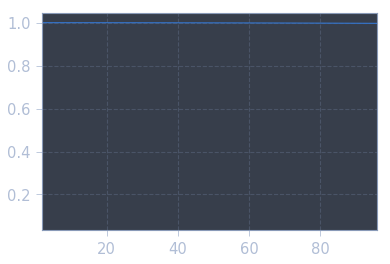

In [32]:
plt.plot(hdulist[2].data)
plt.xlim(2,lmax)